In [5]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import math
import pandas as pd
import scipy
import sys
from scipy.optimize import minimize
from scipy.io import loadmat
from lmfit import Model
from IPython.display import display

MODULE_FULL_PATH = '/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/'
sys.path.insert(1, MODULE_FULL_PATH)
import StatLearnFunks as slf

def find_nearest(value, array):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def g2_func(x, theta, funk):
    w = theta
    return eval(funk)

<IPython.core.display.Javascript object>


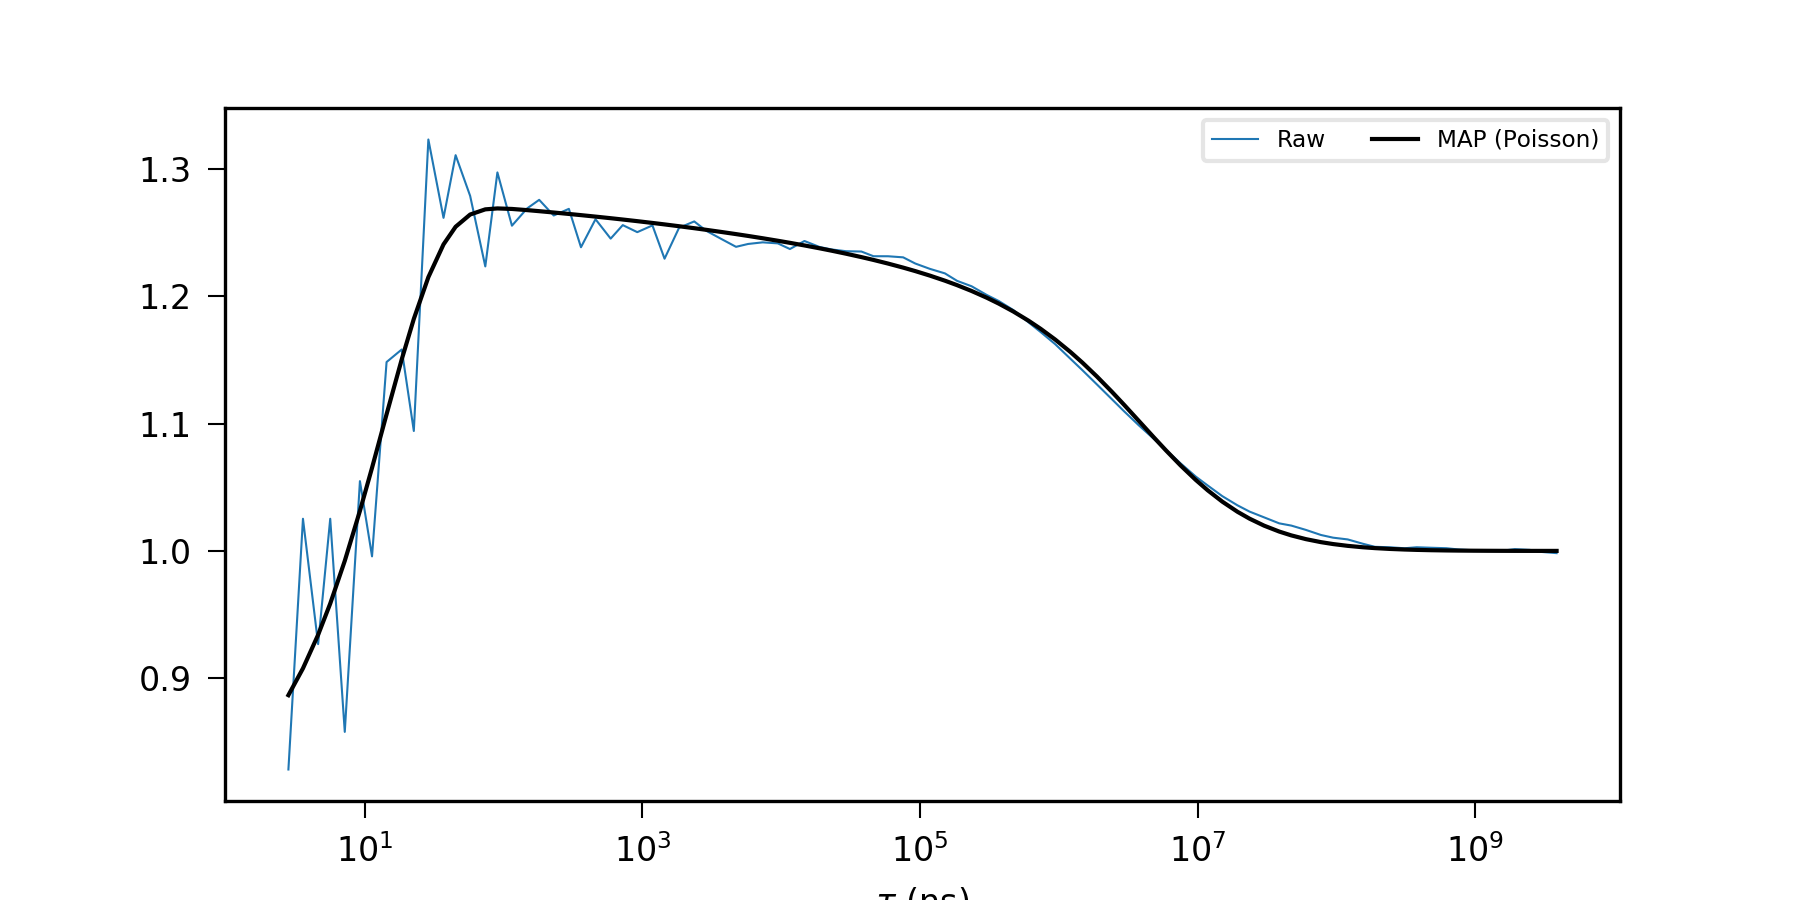

In [6]:
              #A       #B                          #m                   #Td             #k             #Ta
funk    = "1+w[0]*((1-w[1]*x**(0.2-(0.4/(1+np.exp(w[2]**2)))))*1/(1+(x/(w[3]*1.0e6))))-w[4]*np.exp(-x/w[5])" # Bounded m

# Testing input
# theta  = np.array([0.4,    0.1,  0.01,    4.0, 0.5,  10.0]); yy = g2_func(x, theta, funk); plt.plot(x, yy); plt.xscale('log')

# Works with bound m
theta  = np.array([0.4, 0.04,  0.1,    4.0, 0.5,  10.0]) # for nanoseconds
lb     = np.array([0.1,    0,    0, 1.0e-1, 0.1,   1.0]) #
ub     = np.array([1.0, 0.05,   10, 1.0e+1, 1.0, 100.0]) #

# Load data from .mat with scipy
mat = loadmat('/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/data_files/g2_FCS_data2.mat')
auto_corr = mat['auto_corr']; auto_corr = np.squeeze(auto_corr)
cross_corr = mat['cross_corr']; cross_corr = np.squeeze(cross_corr)
lagtimes = mat['lagtimes']; lagtimes = np.squeeze(lagtimes)
xfit_mat = mat['x']; xfit_mat = np.squeeze(xfit_mat)
yfit_mat = mat['yfit']; yfit_mat = np.squeeze(yfit_mat)
index_start = find_nearest(3e-9, lagtimes) #
xraw_mat = lagtimes[index_start:-1]
yraw_mat = cross_corr[index_start:-1,-1]

x = np.array(xraw_mat)
y = np.array(yraw_mat)
x = x*1e9 # convert to ns, scales x-axis better?

%matplotlib notebook
fig1 = plt.figure(1, dpi=150,figsize=(6,3))
plt.plot(x,y,markersize=1, lw=0.5, label="Raw")
plt.xlabel('$\\tau$ (ns)')
plt.xscale('log')

In [7]:
np.random.seed(12345)

print('Finding MAP...')
MAP = slf.MaximumAPosteriori
MAP = MAP.find_MAP(MAP, x, y, Nruns=20, Nvars=len(theta), function=funk, guess=theta, randomizer='bounded', bounds=([lb, ub]))

theta_map = MAP.theta_L # Choose Gaussian MAP parameters to prime MCMC

plt.plot(x,MAP.fit_L,color='k',linewidth=1, label="MAP (Poisson)")
plt.legend(loc='best', fontsize='x-small', ncol=2, framealpha=0.5)

  5%|▌         | 1/20 [00:00<00:03,  5.01it/s]

Finding MAP...
testing


 50%|█████     | 10/20 [00:03<00:03,  3.20it/s]/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/StatLearnFunks.py:1: RuntimeWarning: overflow encountered in exp
  import numpy as np
/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/StatLearnFunks.py:173: RuntimeWarning: invalid value encountered in log
  return np.sum(f-(y0)*np.log(f+1e-13))
/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/StatLearnFunks.py:178: RuntimeWarning: overflow encountered in square
  return 0.5*np.sum(((y0)-f2)**2)
/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/StatLearnFunks.py:183: RuntimeWarning: invalid value encountered in log
  return np.sum(f-(y0)*np.log(f+1e-13)) + 0.5*np.sum(((y0)-f)**2)
/Users/andrewproppe/Bawendi_Lab/python/g2_fitting/StatLearnFunks.py:183: RuntimeWarning: overflow encountered in square
  return np.sum(f-(y0)*np.log(f+1e-13)) + 0.5*np.sum(((y0)-f)**2)
100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


<IPython.core.display.Javascript object>


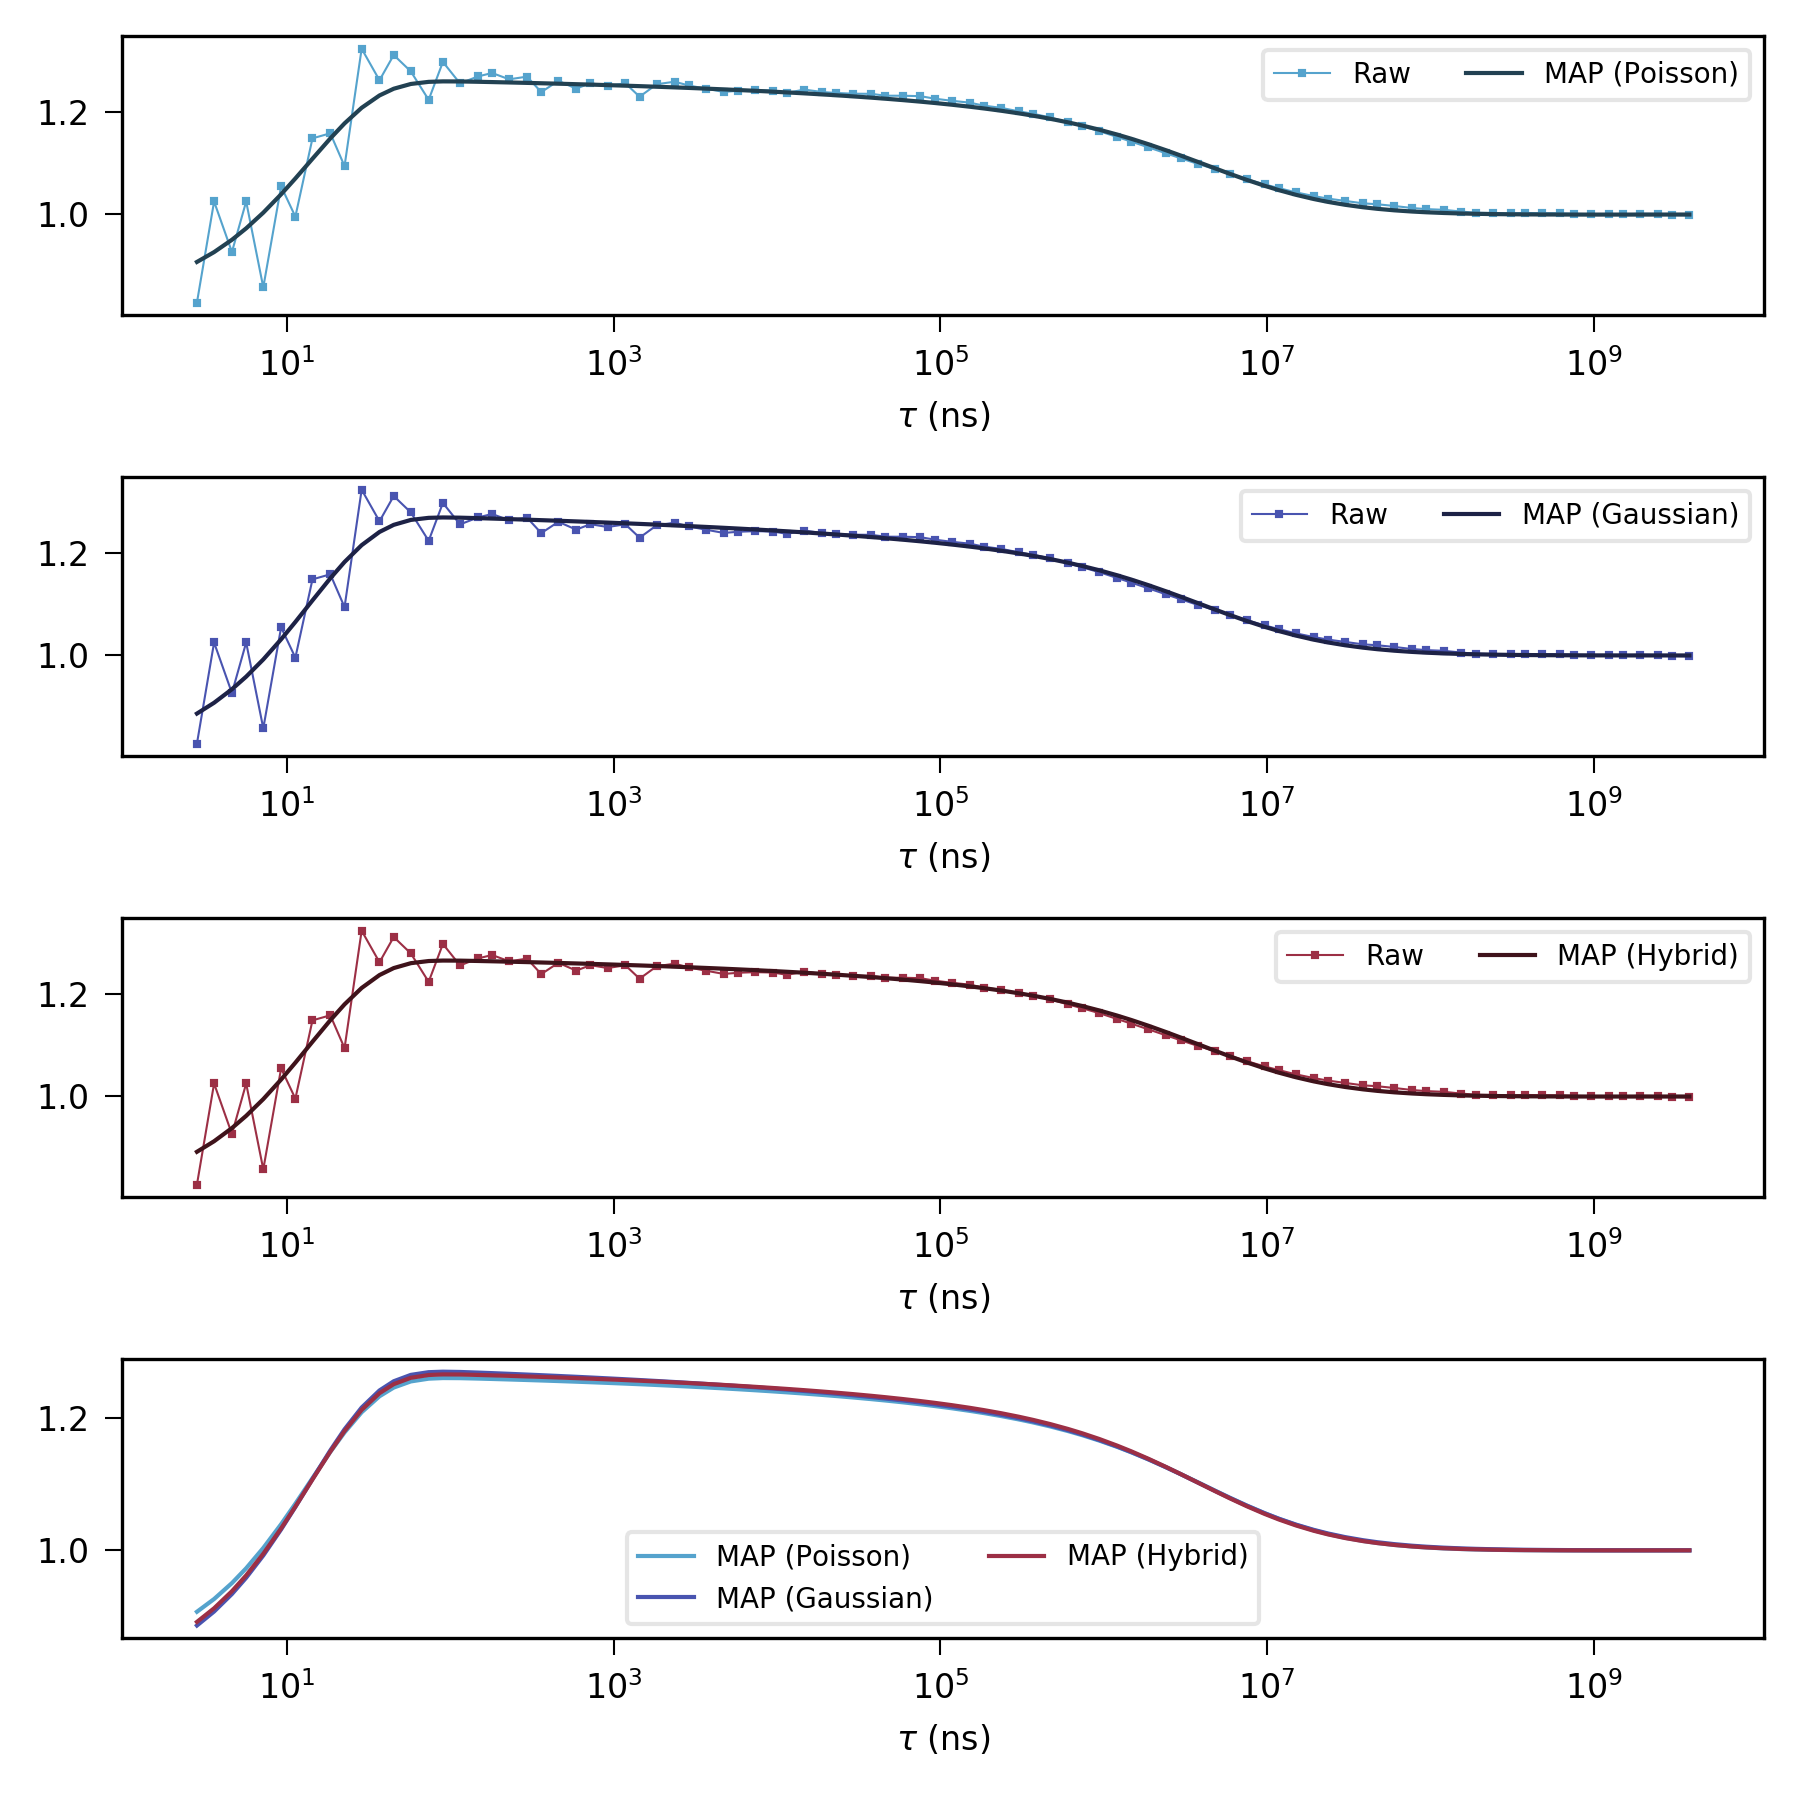

In [8]:
colors = np.array(sns.color_palette("icefire"))
fig1 = plt.figure(2, dpi=150,figsize=(6, 6))

lw_fit = 1
spd1 = 4
spd2 = 1

ax = plt.subplot(spd1, spd2, 1)
plt.plot(x, y, '-s', color=colors[0], lw=0.5, ms=1, label='Raw')
plt.plot(x, MAP.fit_P, color=colors[0]*0.4, lw=lw_fit, label='MAP (Poisson)') # Recovery (Poisson)
plt.xlabel('$\\tau$ (ns)')
plt.xscale('log')
plt.legend(loc='best', fontsize='small', ncol=2, framealpha=0.5)
plt.tight_layout()

ax = plt.subplot(spd1, spd2, 2)
plt.plot(x, y, '-s', color=colors[1], lw=0.5, ms=1, label='Raw')
plt.plot(x, MAP.fit_L, color=colors[1]*0.4, lw=lw_fit, label='MAP (Gaussian)') # Recovery (Gaussian)
plt.xscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.legend(loc='best', fontsize='small', ncol=2, framealpha=0.5); plt.tight_layout()

ax = plt.subplot(spd1, spd2, 3)
plt.plot(x, y, '-s', color=colors[4], lw=0.5, ms=1, label='Raw')
plt.plot(x, MAP.fit_PL, color=colors[4]*0.4, lw=lw_fit, label='MAP (Hybrid)') # Recovery (Hybrid)
plt.xscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.legend(loc='best', fontsize='small', ncol=2, framealpha=0.5); plt.tight_layout()

ax = plt.subplot(spd1, spd2, 4)
plt.plot(x, MAP.fit_P, color=colors[0], lw=lw_fit, label='MAP (Poisson)') # Recovery (Poisson)
plt.plot(x, MAP.fit_L, color=colors[1], lw=lw_fit, label='MAP (Gaussian)') # Recovery (Gaussian)
plt.plot(x, MAP.fit_PL, color=colors[4], lw=lw_fit, label='MAP (Hybrid)') # Recovery (Hybrid)
plt.xscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.legend(loc='best', fontsize='small', ncol=2, framealpha=0.5); plt.tight_layout()